In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.calibration import CalibrationDisplay
from comet_ml import Experiment
import os

np.random.seed(42)

In [2]:
comet_project_name="hockery-primer-t14"
comet_workspace="amandalmia"

In [3]:
def build_log_reg_model(data):
    filter_df = data[['angle', 'is_goal']]
    filter_df = filter_df.dropna()
    
    df_x = filter_df["angle"].values
    df_y = filter_df["is_goal"].values

    x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, 
                                                          random_state=42)
    x_train = x_train.reshape(-1, 1)
    x_val = x_val.reshape(-1, 1)

    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_val)
    accuracy = np.mean(y_val == y_pred) * 100
    print("correctly predicted / total is ", accuracy)
    print(classification_report(y_val, y_pred))
    
data = pd.read_csv("../data/trainvaldata/train_set.csv")
build_log_reg_model(data)

correctly predicted / total is  90.85932801875009
              precision    recall  f1-score   support

           0       0.91      1.00      0.95     58925
           1       0.00      0.00      0.00      5928

    accuracy                           0.91     64853
   macro avg       0.45      0.50      0.48     64853
weighted avg       0.83      0.91      0.87     64853



/Users/amandalmia/workspace/mila/datascience/project/hockey-primer-1/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amandalmia/workspace/mila/datascience/project/hockey-primer-1/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/amandalmia/workspace/mila/datascience/project/hockey-primer-1/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicte

## Question 1

Evaluate the accuracy (i.e. correctly predicted / total) of your model on the validation set. What do you notice? Look at the predictions and discuss your findings. What could be a potential issue? Include these discussions in your blog post.

- Allthough the accuracy is showing up 90% of accuracy, but this number isn't right in my opion. As the major class is 0s, and the ratio of trainign data of shot being goal and not-goal is highly imbalance and is in the order of 1:10. 
- From the classificatinon report its clear that all the test data (validation data) has been predicted to 0s as the output. 


## Question 2
Receiver Operating Characteristic (ROC) curves and the AUC metric of the ROC curve. Include a random classifier baseline, i.e. each shot has a 50% chance of being a goal.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.507


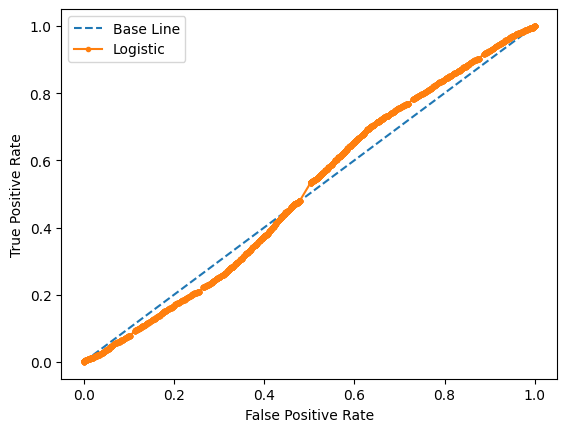

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/amandalmia/hockery-primer-t14/068c2c261d51442aa875e94ab326c63e

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/amandalmia/hockery-primer-t14/068c2c261d51442aa875e94ab326c63e
COMET INFO:   Metrics:
COMET INFO:     accuracy : 90.85932801875009
COMET INFO:     roc      : 0.5069342733649502
COMET INFO:   Others:
COMET INFO:     Name 

In [4]:
def create_roc_auc_curve(data):
    filter_df = data[['angle', 'is_goal']]
    filter_df = filter_df.dropna()
    
    df_x = filter_df["angle"].values
    df_y = filter_df["is_goal"].values

    x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, 
                                                          random_state=42)
    x_train = x_train.reshape(-1, 1)
    x_val = x_val.reshape(-1, 1)
    testy = y_val
    ns_probs = [0 for _ in range(len(testy))]
    
    model = LogisticRegression()
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_val)
    accuracy = np.mean(y_val == y_pred) * 100
    
    predicted_probablities = model.predict_proba(x_val)
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, goal_prob)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, goal_prob)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Base Line')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    metrics = {"roc" : lr_auc, "accuracy":accuracy }
    exp = Experiment(
    api_key=os.environ.get('COMET_API_KEY'),
    project_name=comet_project_name,
    workspace=comet_workspace,
    log_code=True
    )
        
    exp.log_metrics(metrics)
    exp.log_dataset_hash(x_train)
    exp.set_name(name="LogReg Model Angle")
    exp.log_confusion_matrix(y_true=y_val, y_predicted=y_pred)
    exp.end()
data = pd.read_csv("../data/trainvaldata/train_set.csv")
create_roc_auc_curve(data)


## Question 2
The goal rate (#goals / (#no_goals + #goals)) as a function of the shot probability model percentile, i.e. if a value is the 70th percentile, it is above 70% of the data. 

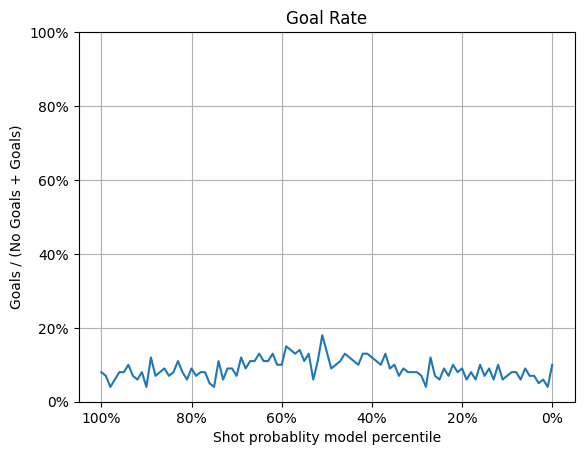

In [5]:
def plot_goal_shot_rate(data):
    filter_df = data[['angle', 'is_goal']]
    filter_df = filter_df.dropna()
    
    df_x = filter_df["angle"].values
    df_y = filter_df["is_goal"].values

    x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, 
                                                          random_state=42)
    x_train = x_train.reshape(-1, 1)
    x_val = x_val.reshape(-1, 1)
    testy = y_val
    ns_probs = [0 for _ in range(len(y_val))]

    model = LogisticRegression()
    model.fit(x_train, y_train)
    predicted_probablities = model.predict_proba(x_val)

    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = round((df.groupby(by='percentile_of_goal').sum() / 
                       df.groupby(by='percentile_of_goal').count())*100)
    goal_rate['percentile'] = goal_rate.index

    graph, (plt1) = plt.subplots(1, 1)
    plt1.plot(goal_rate["percentile"], goal_rate["is_goal"], label='Logistic Regression')
    plt1.set_ylim(0,100)
    plt1.xaxis.set_major_formatter('{x:1.0f}%')
    plt1.yaxis.set_major_formatter('{x:1.0f}%')
    plt1.invert_xaxis()
    plt1.set_xlabel('Shot probablity model percentile')
    plt1.set_ylabel('Goals / (No Goals + Goals)')
    plt.grid()
    plt.title("Goal Rate")
    plt.show()


data = pd.read_csv("../data/trainvaldata/train_set.csv")

plot_goal_shot_rate(data)

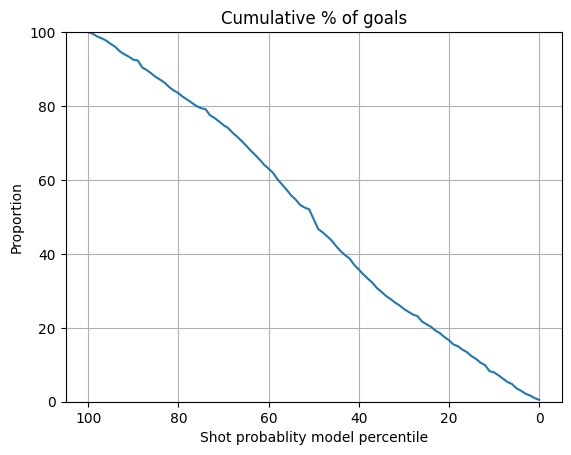

In [6]:
def plot_cumulative_goal(data):
    filter_df = data[['angle', 'is_goal']]
    filter_df = filter_df.dropna()
    
    df_x = filter_df["angle"].values
    df_y = filter_df["is_goal"].values

    x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, 
                                                          random_state=42)
    x_train = x_train.reshape(-1, 1)
    x_val = x_val.reshape(-1, 1)
    testy = y_val
    ns_probs = [0 for _ in range(len(y_val))]

    model = LogisticRegression()
    model.fit(x_train, y_train)
    predicted_probablities = model.predict_proba(x_val)

    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
    df = pd.DataFrame(y_val, columns=["is_goal"])
    df["probablity_of_goal"] = goal_prob
    
    df['percentile_of_goal'] = round(df["probablity_of_goal"].rank(pct = True)*100)
    goal_rate = df.groupby(by='percentile_of_goal').sum()
    goal_rate['percentile'] = goal_rate.index
    
    goal_rate['cum_sum'] = goal_rate['is_goal'].cumsum()
    goal_rate['cum_perc'] = 100*goal_rate['cum_sum'] / goal_rate['is_goal'].sum()


    graph, (plt1) = plt.subplots(1, 1)
    plt1.plot(goal_rate["percentile"], goal_rate["cum_perc"], label='Logistic Regression')
    plt1.set_ylim(0,100)
    plt1.invert_xaxis()
    plt1.set_xlabel('Shot probablity model percentile')
    plt1.set_ylabel('Proportion')
    plt.grid()
    plt.title("Cumulative % of goals")
    plt.show()


data = pd.read_csv("../data/trainvaldata/train_set.csv")

plot_cumulative_goal(data)

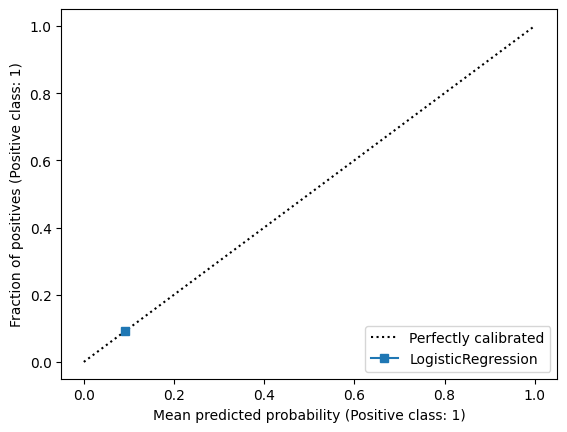

In [7]:
def create_extimator_plot(data):
    filter_df = data[['angle', 'is_goal']]
    filter_df = filter_df.dropna()
    
    df_x = filter_df["angle"].values
    df_y = filter_df["is_goal"].values

    x_train, x_val, y_train, y_val = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, 
                                                          random_state=42)
    x_train = x_train.reshape(-1, 1)
    x_val = x_val.reshape(-1, 1)
    testy = y_val
    ns_probs = [0 for _ in range(len(y_val))]

    model = LogisticRegression()
    model.fit(x_train, y_train)
    predicted_probablities = model.predict_proba(x_val)
    goal_prob = predicted_probablities[:, 1] # taking only the goal probablities
    
#     disp = CalibrationDisplay.from_predictions(y_val, goal_prob)
    disp = CalibrationDisplay.from_estimator(model, x_val, y_val)
    plt.show()

    
data = pd.read_csv("../data/trainvaldata/train_set.csv")
create_extimator_plot(data)
    